# EDA Mortality in Colombia


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import re
import sys
import warnings
warnings.filterwarnings('ignore')


In [2]:
#!pip install seaborn --upgrade to have the same version

We have the DANE information fo 2017 and 2018 mortality reported in Colombia translated previously for column names and infectious deseases in the column 'CAU_HOMOL' into parquet format.

In [3]:
df17 = pd.read_parquet("../parquet_datasets/nofetal2017_new.parquet")
df18 = pd.read_parquet("../parquet_datasets/nofetal2018_new.parquet")

## Mortality information

In [4]:
print("17: ", df17.shape)
print("18: ",df18.shape)


17:  (227624, 70)
18:  (236932, 66)


We noticed that the datasets do not have the same number of columns. Furthermore, not all the columns are needed for our purpose. Then we have to select the columns and merge the dataframes of each year

Dictionary link: 
http://microdatos.dane.gov.co/index.php/catalog/652/data_dictionary#page=F10&tab=data-dictionary

In [5]:
#Check information
df17.columns 

Index(['Unnamed: 0', 'COD_DPTO', 'COD_MUNIC', 'A_DEFUN', 'SIT_DEFUN',
       'OTRSITIODE', 'COD_INST', 'NOM_INST', 'TIPO_DEFUN', 'ANO', 'MES',
       'HORA', 'MINUTOS', 'SEXO', 'EST_CIVIL', 'GRU_ED1', 'GRU_ED2',
       'NIVEL_EDU', 'ULTCURFAL', 'MUERTEPORO', 'SIMUERTEPO', 'OCUPACION',
       'IDPERTET', 'CODPRES', 'CODPTORE', 'CODMUNRE', 'AREA_RES', 'SEG_SOCIAL',
       'IDADMISALU', 'IDCLASADMI', 'PMAN_MUER', 'CONS_EXP', 'MU_PARTO',
       'T_PARTO', 'TIPO_EMB', 'T_GES', 'PESO_NAC', 'EDAD_MADRE', 'N_HIJOSV',
       'N_HIJOSM', 'EST_CIVM', 'NIV_EDUM', 'ULTCURMAD', 'EMB_FAL', 'EMB_SEM',
       'EMB_MES', 'MAN_MUER', 'CODOCUR', 'CODMUNOC', 'C_MUERTE', 'C_MUERTEB',
       'C_MUERTEC', 'C_MUERTED', 'C_MUERTEE', 'ASIS_MED', 'C_DIR1', 'C_DIR12',
       'C_ANT1', 'C_ANT12', 'C_ANT2', 'C_ANT22', 'C_ANT3', 'C_ANT32', 'C_PAT1',
       'C_PAT2', 'C_BAS1', 'C_MCM1', 'CAUSA_666', 'IDPROFCER', 'CAU_HOMOL'],
      dtype='object')

In [6]:
#Check information in the largest dataset
for i in df17.columns:
    print(i,":\n",df17[i].unique())

Unnamed: 0 :
 [     0      1      2 ... 227621 227622 227623]
COD_DPTO :
 ['Putumayo' 'Antioquia' 'Cauca' 'Boyaca' 'Nariño' 'Cordoba' 'Cundinamarca'
 'Valle del Cauca' 'Caldas' 'Sucre' 'Quindio' 'Bogotá' 'Cesar' 'Tolima'
 'Huila' 'Magdalena' 'Bolivar' 'Atlántico' 'Santander' 'Casanare'
 'Norte de Santander' 'Risaralda' 'Arauca' 'Meta' 'Caqueta' 'La guajira'
 'Choco' 'Guainía' 'Guaviare'
 'Archipiélago de San Andrés, Providencia y Santa Catalina' 'Vichada'
 'Amazonas' 'Vaupés']
COD_MUNIC :
 [573 757 250 240 532 753 835 182 511 320 361 254 227   1 486 541 455 495
 834 843 268 129 755 873 190 154 276  88 176  79 380 432 286 430 197 307
 300 183 111 126 238 682 547 206 174 319 296 614 440 690 266 579 520  78
 418 356 297 170  91 360 615 402 572 497 168 718  42 322 754 551  45 411
 759 147 269 513 679 306 175 299 799 284 400 550 101  52 794 498 189 407
 838 313 364 814 758 650 885 660 275 756 770 386 604 378 148 215 631  55
 687 585 899  26  30 670 234 113 599 837 207 678 396  75 763 483 23

There are some things to adjust in the datasets before visualizing the information:

1. Select the columns of interest.
2. Create a column with date in datetype format.
3. Replace ' '  values for NaN for later cleaning.
4. Change the column name 'COD_DPTO' for 'Dpto' because it does not have codes but names of the Colombian departments.

In [7]:
#Keep the columns of interest
columns=['COD_DPTO','A_DEFUN','SIT_DEFUN','ANO', 'MES','SEXO', 'GRU_ED1', 'GRU_ED2',
         'MUERTEPORO','IDPERTET','SEG_SOCIAL','PMAN_MUER','CONS_EXP','CAU_HOMOL']
df2=df17[columns].append(df18[columns])

#Create date column and set it as index
meses={'Enero':1,'Febrero':2,'Marzo':3,'Abril':4,'Mayo':5,'Junio':6,'Julio':7,
      'Agosto':8,'Septiembre':9, 'Octubre':10,'Noviembre':11,'Diciembre':12}
df2['FECHA']=pd.to_datetime(df2.ANO*10000+df2.MES.map(meses)*100+1,format='%Y%m%d')

#Fill blanks with nulls (to be checked)
df2=df2.replace(r'^\s+$', np.nan, regex=True)
df2.set_index('FECHA',inplace=True)

#Change Column name
df2.rename(columns={'COD_DPTO':'Dpto'},inplace=True)
df2.head()

,Dpto,A_DEFUN,SIT_DEFUN,ANO,MES,SEXO,GRU_ED1,GRU_ED2,MUERTEPORO,IDPERTET,SEG_SOCIAL,PMAN_MUER,CONS_EXP,CAU_HOMOL
FECHA,,,,,,,,,,,,,,
2017-01-01,Putumayo,Cabecera municipal,Hospital/clínica,2017,Enero,Masculino,De 50 a 54 años,De 45 a 64 años,2,Ninguno de las anteriores,Subsidiado,Violenta,Médico legista,101
2017-01-01,Putumayo,Cabecera municipal,Vía pública,2017,Enero,Masculino,De 25 a 29 años,De 15 a 44 años,2,Ninguno de las anteriores,Subsidiado,Violenta,Médico legista,101
2017-01-01,Antioquia,Cabecera municipal,Hospital/clínica,2017,Enero,Masculino,De 35 a 39 años,De 15 a 44 años,2,Ninguno de las anteriores,Subsidiado,Violenta,Médico legista,101
2017-01-01,Antioquia,Rural disperso,Vía pública,2017,Enero,Masculino,De 45 a 49 años,De 45 a 64 años,2,Ninguno de las anteriores,Subsidiado,Violenta,Médico legista,101
2017-01-01,Cauca,Rural disperso,Vía pública,2017,Enero,Masculino,De 30 a 34 años,De 15 a 44 años,2,Ninguno de las anteriores,Subsidiado,Violenta,Médico legista,101


##### Edit the CAU_HOMOL column (causes of death)

There are so many causes that are still with codified values and not all the infectious deseases are of our particular interest. Additionally, the acute respiratory infection is in the cathegory '62' (other respiratory deseases). Thus, we create groups by deseases of interest, group all the other deseases in 'No infecciosas' and add the respiratory deseases.

In [8]:
# Cathegorical Variable: 'Infecciosas'
df2['Infecciosas']=np.where(df2.CAU_HOMOL.str.isnumeric(),0,1)

#ADD cause 62 with probably acute respiratory infection
df2.loc[df2.CAU_HOMOL=='62','CAU_HOMOL']='Respiratorias'

# Cathegorical Variable: 'Infecciosas2' (includes respiratory)
df2['Infecciosas2']=np.where(df2.CAU_HOMOL.str.isnumeric(),0,1)

#Others are not infectious deseases
df2.loc[df2.CAU_HOMOL.str.isnumeric(),'CAU_HOMOL']='No Infecciosas'

#Infectious deseases for the analysis
df2['Infecciosas3']=np.where(df2.CAU_HOMOL.isin(['Ciertas enfermedades transmitidas por vectores y rabia','Respiratorias']),1,0)

In [9]:
#Check information
for i in df2.columns:
    print(i,":\n",df2[i].unique())

Dpto :
 ['Putumayo' 'Antioquia' 'Cauca' 'Boyaca' 'Nariño' 'Cordoba' 'Cundinamarca'
 'Valle del Cauca' 'Caldas' 'Sucre' 'Quindio' 'Bogotá' 'Cesar' 'Tolima'
 'Huila' 'Magdalena' 'Bolivar' 'Atlántico' 'Santander' 'Casanare'
 'Norte de Santander' 'Risaralda' 'Arauca' 'Meta' 'Caqueta' 'La guajira'
 'Choco' 'Guainía' 'Guaviare'
 'Archipiélago de San Andrés, Providencia y Santa Catalina' 'Vichada'
 'Amazonas' 'Vaupés']
A_DEFUN :
 ['Cabecera municipal' 'Rural disperso'
 'Centro poblado (Inspección, corregimiento o caserío)' 'Sin información']
SIT_DEFUN :
 ['Hospital/clínica' 'Vía pública' 'Casa /domicilio' 'Otro'
 'Lugar de trabajo' 'Centro /puesto de salud' 'Sin información']
ANO :
 [2017 2018]
MES :
 ['Enero' 'Febrero' 'Marzo' 'Abril' 'Mayo' 'Junio' 'Julio' 'Agosto'
 'Septiembre' 'Noviembre' 'Octubre' 'Diciembre']
SEXO :
 ['Masculino' 'Femenino' 'Indeterminado']
GRU_ED1 :
 ['De 50 a 54 años' 'De 25 a 29 años' 'De 35 a 39 años' 'De 45 a 49 años'
 'De 30 a 34 años' 'De 75 a 79 años' 'De 90 a 9

##### Null values

In [10]:
df2.isnull().sum()

Dpto                0
A_DEFUN             0
SIT_DEFUN           0
ANO                 0
MES                 0
SEXO                0
GRU_ED1             0
GRU_ED2             0
MUERTEPORO      17481
IDPERTET            0
SEG_SOCIAL          0
PMAN_MUER           0
CONS_EXP            0
CAU_HOMOL           0
Infecciosas         0
Infecciosas2        0
Infecciosas3        0
dtype: int64

In [11]:
# Change null values
df2.MUERTEPORO.fillna(9,inplace=True) #9 :sin información
df2.isna().sum()

Dpto            0
A_DEFUN         0
SIT_DEFUN       0
ANO             0
MES             0
SEXO            0
GRU_ED1         0
GRU_ED2         0
MUERTEPORO      0
IDPERTET        0
SEG_SOCIAL      0
PMAN_MUER       0
CONS_EXP        0
CAU_HOMOL       0
Infecciosas     0
Infecciosas2    0
Infecciosas3    0
dtype: int64

#### Plot Infectious Desease per Year

Plot death toll in total by infectious deseases.


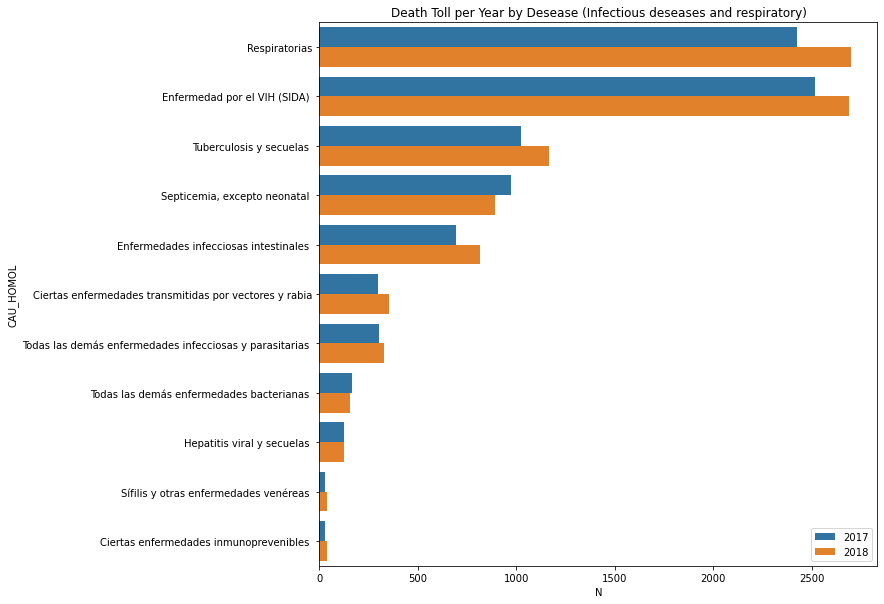

In [12]:
temp=df2[df2.Infecciosas2==1][['CAU_HOMOL','ANO','MES']].rename(columns={'MES':'N'})\
.groupby(['CAU_HOMOL','ANO']).count().reset_index().sort_values(by=['N'],ascending=False)
fig = plt.figure(figsize=(10,10))
sns.barplot(data=temp, x="N", y="CAU_HOMOL",hue="ANO")
plt.legend(loc='lower right')
plt.title('Death Toll per Year by Desease (Infectious deseases and respiratory)');

##### Time series plot of monthly deaths by desease

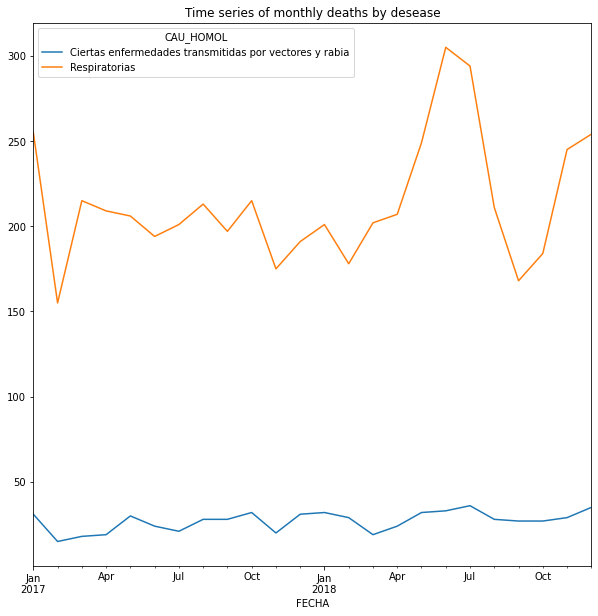

In [13]:
#Plot of Desease Number by years
df2[df2.Infecciosas3==1].reset_index().groupby(['FECHA','CAU_HOMOL']).count()['Dpto'].unstack('CAU_HOMOL').fillna(0)\
.plot.line(figsize=(10,10))
plt.title('Time series of monthly deaths by desease');

In [14]:
df3=df2[df2.Infecciosas3==1].reset_index().groupby(['FECHA','CAU_HOMOL']).count()['Dpto'].reset_index().fillna(0).rename(columns={'Dpto':'Total'})
df3['AÑO']=df3['FECHA'].dt.year
df3.groupby(['CAU_HOMOL','AÑO']).sum().groupby('CAU_HOMOL').mean()

,Total
CAU_HOMOL,
Ciertas enfermedades transmitidas por vectores y rabia,324
Respiratorias,2562


In the period from May to August of 2018 there is a peak of respiratory desease deaths. 

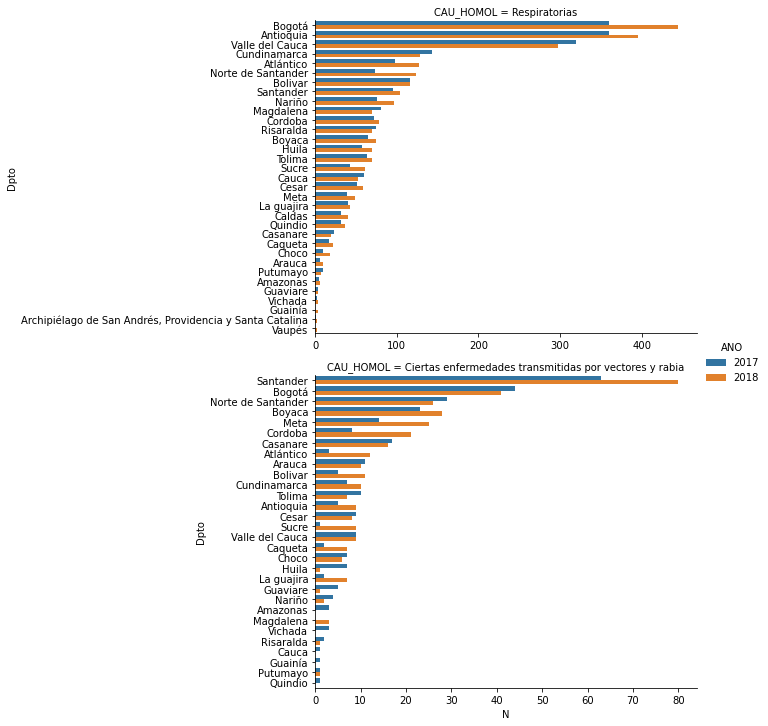

In [15]:
temp=df2[df2.Infecciosas3==1][['CAU_HOMOL','ANO','MES','Dpto']].rename(columns={'MES':'N'})\
.groupby(['Dpto','ANO','CAU_HOMOL']).agg({'N':'count'}).reset_index().sort_values(by=['CAU_HOMOL','N'], ascending= False)

g = sns.catplot(data=temp, x='N', y='Dpto', hue='ANO', row='CAU_HOMOL',
                kind='bar', sharex=False, sharey= False, height=5, aspect=2);

In [16]:
df2.CAU_HOMOL.unique()

array(['No Infecciosas', 'Enfermedad por el VIH (SIDA) ', 'Respiratorias',
       'Septicemia, excepto neonatal ',
       'Todas las demás enfermedades infecciosas y parasitarias ',
       'Tuberculosis y secuelas ',
       'Enfermedades infecciosas intestinales ',
       'Todas las demás enfermedades bacterianas ',
       'Ciertas enfermedades transmitidas por vectores y rabia',
       'Hepatitis viral y secuelas ',
       'Sífilis y otras enfermedades venéreas ',
       'Ciertas enfermedades inmunoprevenibles '], dtype=object)

In [17]:
df2.GRU_ED2.unique()

array(['De 45 a 64 años', 'De 15 a 44 años', 'De 65 y mas años',
       'De 1 a 4 años', 'De 5 a 14 años', 'Edad desconocida',
       'Menor de 1 año'], dtype=object)

In [18]:
df3=df2[['Dpto','SEXO','GRU_ED1','CAU_HOMOL']].reset_index()
df3

,FECHA,Dpto,SEXO,GRU_ED1,CAU_HOMOL
0,2017-01-01,Putumayo,Masculino,De 50 a 54 años,No Infecciosas
1,2017-01-01,Putumayo,Masculino,De 25 a 29 años,No Infecciosas
2,2017-01-01,Antioquia,Masculino,De 35 a 39 años,No Infecciosas
3,2017-01-01,Antioquia,Masculino,De 45 a 49 años,No Infecciosas
4,2017-01-01,Cauca,Masculino,De 30 a 34 años,No Infecciosas
...,...,...,...,...,...
464551,2018-04-01,Sucre,Masculino,De 50 a 54 años,"Septicemia, excepto neonatal"
464552,2018-12-01,Risaralda,Masculino,De 70 a 74 años,No Infecciosas
464553,2018-12-01,Risaralda,Masculino,De 90 a 94 años,No Infecciosas
464554,2018-07-01,Santander,Femenino,De 80 a 84 años,No Infecciosas


In [19]:
#import unicodedata
#def strip_accents(s):
 #  return ''.join(c for c in unicodedata.normalize('NFD', s)
  #                if unicodedata.category(c) != 'Mn')
#df2.Dpto=df2.Dpto.apply(strip_accents)

In [20]:
g04=['Menor de una hora','Menor de un día', 'De 1 a 6 días','De 7 a 27 días','De 28 a 29 días',
   'De 1 a 5 meses','De 6 a 11 meses','De 1 año', 'De 2 a 4 años']
df3.loc[ df3.GRU_ED1.isin(g04),'GRU_ED1']='De 0 a 4 años'
df3.GRU_ED1.unique()

array(['De 50 a 54 años', 'De 25 a 29 años', 'De 35 a 39 años',
       'De 45 a 49 años', 'De 30 a 34 años', 'De 75 a 79 años',
       'De 90 a 94 años', 'De 65 a 69 años', 'De 15 a 19 años',
       'De 40 a 44 años', 'De 80 a 84 años', 'De 60 a 64 años',
       'De 55 a 59 años', 'De 95 a 99 años', 'De 85 a 89 años',
       'De 70 a 74 años', 'De 100 años y más', 'De 20 a 24 años',
       'De 0 a 4 años', 'De 5 a 9 años', 'De 10 a 14 años',
       'Edad desconocida'], dtype=object)

In [21]:
df3.rename(columns={'Dpto':'DPTO','CAU_HOMOL':'CAUSA','GRU_ED1':'RANGOEDAD'},inplace=True)
df3.head()

,FECHA,DPTO,SEXO,RANGOEDAD,CAUSA
0,2017-01-01,Putumayo,Masculino,De 50 a 54 años,No Infecciosas
1,2017-01-01,Putumayo,Masculino,De 25 a 29 años,No Infecciosas
2,2017-01-01,Antioquia,Masculino,De 35 a 39 años,No Infecciosas
3,2017-01-01,Antioquia,Masculino,De 45 a 49 años,No Infecciosas
4,2017-01-01,Cauca,Masculino,De 30 a 34 años,No Infecciosas


## Acute Respiratory Infection Mortality Addition

###  Respiratory Mortality Dataset adjustment

In [22]:
ira=pd.read_csv('../csv_datasets/IRA_2018_Datos_2018_600.csv',encoding='latin1', low_memory= False)

In [23]:
ira

,CONSECUTIVE,COD_EVE,FEC_NOT,SEMANA,ANO,COD_PRE,COD_SUB,EDAD,UNI_MED,SEXO,...,FM_GRADO,VERSION,confirmados,est_f_caso,Evento,estado_final_de_caso,Departanento_ocurrencia,Municipio_ocurrencia,Departamento_residencia,Municipio_residencia
0,5730060,600,2019-03-22,44,2018,561502129,1,5,2,F,...,NaN,NaN,1,4,MORTALIDAD POR IRA,Confirmado por Clínica,ANTIOQUIA,LA CEJA,ANTIOQUIA,LA CEJA
1,5730080,600,2018-11-20,47,2018,1300101187,1,3,2,F,...,NaN,NaN,1,4,MORTALIDAD POR IRA,Confirmado por Clínica,ATLANTICO,LURUACO,ATLANTICO,LURUACO
2,5725524,600,2018-08-25,34,2018,1765300646,1,8,2,M,...,NaN,NaN,1,4,MORTALIDAD POR IRA,Confirmado por Clínica,CALDAS,SALAMINA,CALDAS,LA MERCED
3,5729938,600,2018-11-05,45,2018,4129800419,1,6,2,F,...,NaN,NaN,1,4,MORTALIDAD POR IRA,Confirmado por Clínica,HUILA,GARZON,HUILA,GARZON
4,5941944,600,2018-08-18,33,2018,4100100572,1,1,1,M,...,NaN,NaN,1,4,MORTALIDAD POR IRA,Confirmado por Clínica,HUILA,GARZON,HUILA,GARZON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,5726022,600,2018-05-26,21,2018,7300101742,1,5,2,F,...,NaN,NaN,1,3,MORTALIDAD POR IRA,Confirmado por laboratorio,TOLIMA,IBAGUE,TOLIMA,IBAGUE
543,5940365,600,2018-01-31,4,2018,7300100909,1,9,2,M,...,NaN,NaN,1,4,MORTALIDAD POR IRA,Confirmado por Clínica,TOLIMA,IBAGUE,TOLIMA,IBAGUE
544,5725531,600,2018-10-06,34,2018,7300101047,1,3,2,M,...,NaN,NaN,1,4,MORTALIDAD POR IRA,Confirmado por Clínica,TOLIMA,IBAGUE,TOLIMA,IBAGUE
545,5725777,600,2018-10-04,39,2018,7300101047,1,5,2,F,...,NaN,NaN,1,3,MORTALIDAD POR IRA,Confirmado por laboratorio,TOLIMA,IBAGUE,TOLIMA,IBAGUE


In [24]:
ira.columns

Index(['CONSECUTIVE', 'COD_EVE', 'FEC_NOT', 'SEMANA', 'ANO', 'COD_PRE',
       'COD_SUB', 'EDAD', 'UNI_MED', 'SEXO', 'COD_PAIS_O', 'COD_DPTO_O',
       'COD_MUN_O', 'AREA', 'LOCALIDAD', 'CEN_POBLA', 'VEREDA', 'BAR_VER',
       'OCUPACION', 'TIP_SS', 'COD_ASE', 'PER_ETN', 'GRU_POB', 'GP_DISCAPA',
       'GP_DESPLAZ', 'GP_MIGRANT', 'GP_CARCELA', 'GP_GESTAN', 'GP_INDIGEN',
       'GP_POBICFB', 'GP_MAD_COM', 'GP_DESMOVI', 'GP_PSIQUIA', 'GP_VIC_VIO',
       'GP_OTROS', 'COD_DPTO_R', 'COD_MUN_R', 'COD_DPTO_N', 'COD_MUN_N',
       'FEC_CON', 'INI_SIN', 'TIP_CAS', 'PAC_HOS', 'FEC_HOS', 'CON_FIN',
       'FEC_DEF', 'AJUSTE', 'FECHA_NTO', 'CER_DEF', 'CBMTE', 'FEC_ARC_XL',
       'FEC_AJU', 'FM_FUERZA', 'FM_UNIDAD', 'FM_GRADO', 'VERSION',
       'confirmados', 'est_f_caso', 'Evento', 'estado_final_de_caso',
       'Departanento_ocurrencia', 'Municipio_ocurrencia',
       'Departamento_residencia', 'Municipio_residencia'],
      dtype='object')

In [25]:
ira2=ira[['COD_DPTO_O','Departanento_ocurrencia','FEC_DEF','EDAD','SEXO']]
ira2

,COD_DPTO_O,Departanento_ocurrencia,FEC_DEF,EDAD,SEXO
0,5,ANTIOQUIA,2018-10-30,5,F
1,8,ATLANTICO,2018-11-18,3,F
2,17,CALDAS,2018-08-25,8,M
3,41,HUILA,2018-11-05,6,F
4,41,HUILA,2018-08-18,1,M
...,...,...,...,...,...
542,73,TOLIMA,2018-05-26,5,F
543,73,TOLIMA,2018-01-22,9,M
544,73,TOLIMA,2018-08-20,3,M
545,73,TOLIMA,2018-09-28,5,F


In [26]:
#Replace department code by same names of Nofetal
Deptos={ 5: 'Antioquia', 8: 'Atlántico', 11: 'Bogotá', 13: 'Bolivar', 15: 'Boyaca', 17: 'Caldas', 18: 'Caqueta', 19: 'Cauca', 20: 'Cesar', 23: 'Cordoba', 25: 'Cundinamarca', 27: 'Choco', 41: 'Huila', 44: 'La guajira', 47: 'Magdalena', 50: 'Meta', 52: 'Nariño', 54: 'Norte de Santander', 63: 'Quindio', 66: 'Risaralda', 68: 'Santander', 70: 'Sucre', 73: 'Tolima', 76: 'Valle del Cauca', 81: 'Arauca', 85: 'Casanare', 86: 'Putumayo', 88: 'Archipiélago de San Andrés, Providencia y Santa Catalina', 91: 'Amazonas', 94: 'Guainía', 95: 'Guaviare', 97: 'Vaupés', 99: 'Vichada'}
ira2['DPTO']=ira2['COD_DPTO_O'].map(Deptos)
ira2.DPTO.unique()

array(['Antioquia', 'Atlántico', 'Caldas', 'Huila', 'Magdalena',
       'Caqueta', 'Cauca', 'Cesar', 'Cundinamarca', 'La guajira',
       'Boyaca', 'Norte de Santander', 'Risaralda', 'Arauca', 'Cordoba',
       'Choco', 'Bogotá', 'Bolivar', 'Santander', 'Tolima', 'Casanare',
       'Meta', 'Nariño', 'Sucre', 'Quindio', 'Vichada', 'Valle del Cauca',
       'Vaupés', nan, 'Putumayo', 'Amazonas', 'Guainía'], dtype=object)

In [27]:
ira2[ira2.DPTO.isna()]

,COD_DPTO_O,Departanento_ocurrencia,FEC_DEF,EDAD,SEXO,DPTO
169,1,EXTERIOR,2018-01-16,1,M,NaN
301,1,EXTERIOR,2018-11-12,1,M,NaN
302,1,EXTERIOR,2018-07-08,1,F,NaN
303,1,EXTERIOR,2018-07-20,6,F,NaN
304,1,EXTERIOR,2018-03-13,7,F,NaN
305,1,EXTERIOR,2018-03-31,5,F,NaN
306,1,EXTERIOR,2018-07-10,1,M,NaN
307,1,EXTERIOR,2018-04-21,1,M,NaN
308,1,EXTERIOR,2018-01-15,3,M,NaN
309,1,EXTERIOR,2018-01-23,2,F,NaN


As the NaN values are "abroad", these rows are not of our interest, so they are ommited

In [28]:
ira2=ira2[~ira2.DPTO.isna()]
ira2.DPTO.unique()

array(['Antioquia', 'Atlántico', 'Caldas', 'Huila', 'Magdalena',
       'Caqueta', 'Cauca', 'Cesar', 'Cundinamarca', 'La guajira',
       'Boyaca', 'Norte de Santander', 'Risaralda', 'Arauca', 'Cordoba',
       'Choco', 'Bogotá', 'Bolivar', 'Santander', 'Tolima', 'Casanare',
       'Meta', 'Nariño', 'Sucre', 'Quindio', 'Vichada', 'Valle del Cauca',
       'Vaupés', 'Putumayo', 'Amazonas', 'Guainía'], dtype=object)

In [29]:
ira2['MES']=pd.to_datetime(ira2.FEC_DEF).dt.month
ira2

,COD_DPTO_O,Departanento_ocurrencia,FEC_DEF,EDAD,SEXO,DPTO,MES
0,5,ANTIOQUIA,2018-10-30,5,F,Antioquia,10
1,8,ATLANTICO,2018-11-18,3,F,Atlántico,11
2,17,CALDAS,2018-08-25,8,M,Caldas,8
3,41,HUILA,2018-11-05,6,F,Huila,11
4,41,HUILA,2018-08-18,1,M,Huila,8
...,...,...,...,...,...,...,...
542,73,TOLIMA,2018-05-26,5,F,Tolima,5
543,73,TOLIMA,2018-01-22,9,M,Tolima,1
544,73,TOLIMA,2018-08-20,3,M,Tolima,8
545,73,TOLIMA,2018-09-28,5,F,Tolima,9


In [30]:
ira2['FECHA']=pd.to_datetime(2018*10000+ira2.MES.copy()*100+1,format='%Y%m%d')
ira2


,COD_DPTO_O,Departanento_ocurrencia,FEC_DEF,EDAD,SEXO,DPTO,MES,FECHA
0,5,ANTIOQUIA,2018-10-30,5,F,Antioquia,10,2018-10-01
1,8,ATLANTICO,2018-11-18,3,F,Atlántico,11,2018-11-01
2,17,CALDAS,2018-08-25,8,M,Caldas,8,2018-08-01
3,41,HUILA,2018-11-05,6,F,Huila,11,2018-11-01
4,41,HUILA,2018-08-18,1,M,Huila,8,2018-08-01
...,...,...,...,...,...,...,...,...
542,73,TOLIMA,2018-05-26,5,F,Tolima,5,2018-05-01
543,73,TOLIMA,2018-01-22,9,M,Tolima,1,2018-01-01
544,73,TOLIMA,2018-08-20,3,M,Tolima,8,2018-08-01
545,73,TOLIMA,2018-09-28,5,F,Tolima,9,2018-09-01


<AxesSubplot:>

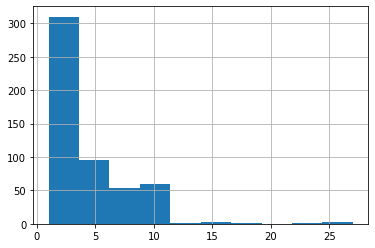

In [31]:
ira2.EDAD.hist()

<AxesSubplot:>

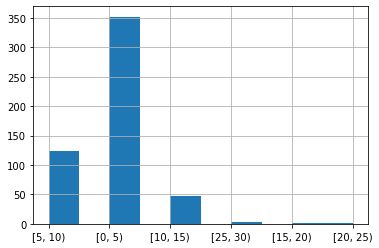

In [32]:
seg=list(range(0, 109, 5))
ira2['RANGOEDAD']= pd.cut(ira2.EDAD,seg,right=False).astype('str').replace('nan',np.NaN)
ira2.RANGOEDAD.hist()

<AxesSubplot:>

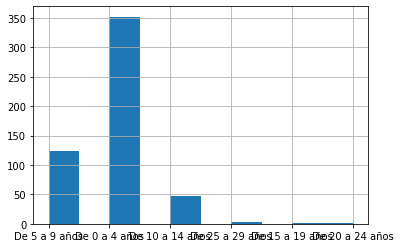

In [33]:
DicRangos={0: 'De 0 a 4 años', 10: 'De 10 a 14 años', 100: 'De 100 años y más', 15: 'De 15 a 19 años', 20: 'De 20 a 24 años',
 25: 'De 25 a 29 años', 30: 'De 30 a 34 años', 35: 'De 35 a 39 años', 40: 'De 40 a 44 años', 45: 'De 45 a 49 años',
 5: 'De 5 a 9 años', 50: 'De 50 a 54 años', 55: 'De 55 a 59 años', 60: 'De 60 a 64 años', 65: 'De 65 a 69 años',
 70: 'De 70 a 74 años', 75: 'De 75 a 79 años', 80: 'De 80 a 84 años', 85: 'De 85 a 89 años', 90: 'De 90 a 94 años', 95: 'De 95 a 99 años'}

ira2['Rango2']=[int(re.findall(r'\d+', a)[0]) for a in  ira2['RANGOEDAD']]
ira2['RANGOEDAD']=ira2.Rango2.map(DicRangos)
ira2.RANGOEDAD.hist()

In [34]:
dics={'F':'Femenino','M':'Masculino'}
ira2.SEXO=ira2.SEXO.map(dics)
ira2.SEXO.value_counts()

Masculino    284
Femenino     244
Name: SEXO, dtype: int64

In [35]:
ira2.count()

COD_DPTO_O                 528
Departanento_ocurrencia    528
FEC_DEF                    528
EDAD                       528
SEXO                       528
DPTO                       528
MES                        528
FECHA                      528
RANGOEDAD                  528
Rango2                     528
dtype: int64

In [36]:
ira2['CAUSA']='IRA'
ira2=ira2.reset_index()[['FECHA','DPTO','SEXO','RANGOEDAD','CAUSA']]
ira2

,FECHA,DPTO,SEXO,RANGOEDAD,CAUSA
0,2018-10-01,Antioquia,Femenino,De 5 a 9 años,IRA
1,2018-11-01,Atlántico,Femenino,De 0 a 4 años,IRA
2,2018-08-01,Caldas,Masculino,De 5 a 9 años,IRA
3,2018-11-01,Huila,Femenino,De 5 a 9 años,IRA
4,2018-08-01,Huila,Masculino,De 0 a 4 años,IRA
...,...,...,...,...,...
523,2018-05-01,Tolima,Femenino,De 5 a 9 años,IRA
524,2018-01-01,Tolima,Masculino,De 5 a 9 años,IRA
525,2018-08-01,Tolima,Masculino,De 0 a 4 años,IRA
526,2018-09-01,Tolima,Femenino,De 5 a 9 años,IRA


In [37]:
##union
dffinal=df3.append(ira2).sort_values(by='FECHA').reset_index().drop(columns='index')
dffinal

,FECHA,DPTO,SEXO,RANGOEDAD,CAUSA
0,2017-01-01,Putumayo,Masculino,De 50 a 54 años,No Infecciosas
1,2017-01-01,Boyaca,Masculino,De 80 a 84 años,No Infecciosas
2,2017-01-01,Boyaca,Femenino,De 80 a 84 años,No Infecciosas
3,2017-01-01,Quindio,Masculino,De 85 a 89 años,No Infecciosas
4,2017-01-01,Quindio,Masculino,De 95 a 99 años,No Infecciosas
...,...,...,...,...,...
465079,2018-12-01,Atlántico,Masculino,De 80 a 84 años,No Infecciosas
465080,2018-12-01,Antioquia,Femenino,De 85 a 89 años,No Infecciosas
465081,2018-12-01,Norte de Santander,Femenino,De 65 a 69 años,No Infecciosas
465082,2018-12-01,Nariño,Femenino,De 80 a 84 años,No Infecciosas


In [38]:
dffinal.to_parquet('../parquet_datasets/Nofetal_S.parquet')